# ML model generation

This notebook creates and trains a simple sine wave detection model by following the example provided at https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/examples/hello_world/README.md. At the end, the model is exported as `model.bin`.

In [4]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import struct

save_model = False

In [5]:
def get_data(seed=0):
    '''Generates data for the model'''
    np.random.seed(seed)
    x = np.random.uniform(low=0, high=2*np.pi, size=1000)
    np.random.shuffle(x)
    x = torch.from_numpy(x).view(-1,1).float()
    
    y = torch.sin(x)

    return x,y

In [24]:
class Model(nn.Module):
    def __init__(self, dim):
        super(Model, self).__init__()
        self.dim = dim
        self.layers = nn.ModuleList([nn.Linear(1, dim), 
                                    nn.Linear(dim, dim)])
        self.activation = nn.ReLU()
        self.out = nn.Linear(dim, 1)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
        
        x = self.out(x)
        
        return x

0.49399641156196594
0.00030184356728568673
8.632766548544168e-05
6.686744745820761e-05
6.106367072788998e-05
5.065406730864197e-05
9.810503979679197e-05
6.614789890591055e-05
5.0160429964307696e-05
5.098251858726144e-05


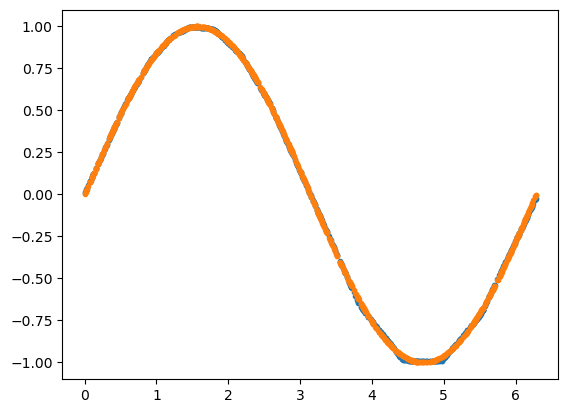

In [16]:
model = Model(16)
loss_fn = nn.MSELoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.002)
x,y = get_data()

for epoch in range(10000):
    opt.zero_grad()
    out = model(x)
    loss = loss_fn(out, y)
    loss.backward()
    opt.step()
    if epoch%1000==0:
        print(loss.item())

xval, yval = get_data()
plt.plot(xval.numpy(), model(xval).detach().numpy(), ".")
plt.plot(xval.numpy(), yval.numpy(), ".")


In [133]:
def serialize_fp32(file, tensor):
    """ writes one fp32 tensor to file that is open in wb mode """
    d = tensor.detach().cpu().view(-1).to(torch.float32).numpy()
    b = struct.pack(f'{len(d)}f', *d)
    file.write(b)
 
    
if save_model:
    filepath = "model.bin"

    f = open(filepath, "wb")

    header = struct.pack("i", model.dim)
    f.write(header)
    pad = 256 - f.tell() # pad rest with zeros
    assert pad >= 0
    f.write(b'\0'*pad)
    
    weights = [*[layer.weight for layer in model.layers], model.out.weight]
    bias = [*[layer.bias for layer in model.layers], model.out.bias]
    
    for w in weights:
        serialize_fp32(f, w)
    
    for b in bias:
        serialize_fp32(f, b)

    f.close()

In [134]:
def write_weights():
    ''' writes the model parameters to check if "model.bin" is written correctly '''

    f = open("model.bin", "rb")
    dim = struct.unpack('i', f.read(4))[0]
    f.seek(256)
    wi = struct.unpack('f'*dim, f.read(4*dim))
    wh = struct.unpack('f'*dim*dim, f.read(4*dim*dim))
    wo = struct.unpack('f'*dim, f.read(4*dim))
    bi = struct.unpack('f'*dim, f.read(4*dim))
    bh = struct.unpack('f'*dim, f.read(4*dim))
    bo = struct.unpack('f', f.read(4))
    f.close()
    
    f = open("weightsp.txt", "w")
    weights = [*wi, *wh, *wo, *bi, *bh, *bo]
    for w in weights:
        f.write("{}\n".format(w))
    f.close()

In [17]:
def write_output(model):
    ''' writes model outputs to compare these to model outputs in C '''
    
    f = open("model.bin", "rb")
    dim = struct.unpack('i', f.read(4))[0]
    f.seek(256)
    wi = torch.tensor(struct.unpack('f'*dim, f.read(4*dim))).view(dim,1)
    wh = torch.tensor(struct.unpack('f'*dim*dim, f.read(4*dim*dim))).view(dim,dim)
    wo = torch.tensor(struct.unpack('f'*dim, f.read(4*dim))).view(1,dim)
    bi = torch.tensor(struct.unpack('f'*dim, f.read(4*dim)))
    bh = torch.tensor(struct.unpack('f'*dim, f.read(4*dim)))
    bo = torch.tensor(struct.unpack('f', f.read(4)))
    f.close()
    
    i = 0
    params = [wi, bi, wh, bh, wo, bo]
    for p in model.parameters():
        p.data = params[i]
        i += 1

    inputs = torch.tensor([0.001, 1.57, 3.14, 6.28]).view(-1,1);
    
    f = open("outputp.txt", "w")
    outputs = model(inputs).detach().cpu()
    for out in outputs:
        f.write("{}\n".format(float(out)))
    f.close()